In [3]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [4]:
mnist = torchvision.datasets.MNIST("data", download=False, transform=torchvision.transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist, batch_size=100, shuffle=True)

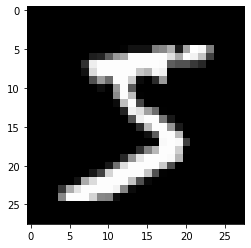

In [5]:
#plt.imshow(mnist[0])
t, label = mnist[0]
plt.imshow(t.numpy()[0], cmap="gray")

In [4]:
t.shape

torch.Size([1, 28, 28])

In [6]:
def gauss_filter(img_tensor, mu, sigma):
    normal = torch.distributions.Normal(mu, sigma)
    return img_tensor + normal.sample(img_tensor.shape)

def remove_pixel_filter(img_tensor, zero_chance, fill_chance, fill_value):
    img_tensor = img_tensor.clone()
    uniform = torch.distributions.Uniform(0, 1)
    index = uniform.sample(img_tensor.shape)
    img_tensor[index < zero_chance] = 0
    img_tensor[index > 1 - fill_chance] = fill_value
    return img_tensor

def change_n_pixel_filter(img_tensor: torch.Tensor, n):
    shape = img_tensor.shape
    img_tensor = img_tensor.clone().flatten(start_dim=1)
    for i in range(img_tensor.shape[0]):
        index = np.random.choice(img_tensor.shape[1], n, replace=False)
        mask = img_tensor[i, index] >= 0.5
        img_tensor[i, index[mask]] = 0
        img_tensor[i, index[~mask]] = 1
    return img_tensor.reshape(shape)

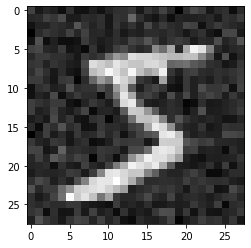

In [6]:
plt.imshow(gauss_filter(t[0], 0, 0.1), cmap="gray")

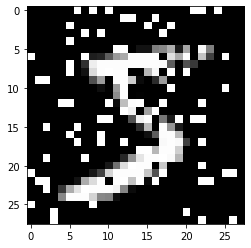

In [7]:
plt.imshow(remove_pixel_filter(t[0], 0.1, 0.1, 1), cmap="gray")

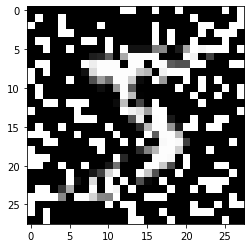

In [58]:
plt.imshow(change_n_pixel_filter(t, 200)[0], cmap="gray")

In [19]:
def plot(model, img, figsize=(20, 10), label=""):
    with torch.no_grad():
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        fig.suptitle(f"Label: {label}")
        ax[0].imshow(img.squeeze().numpy(), cmap="gray")
        ax[0].set_title("Orig")
        ax[1].imshow(model(img.unsqueeze(0)).squeeze().numpy(), cmap="gray")
        ax[1].set_title("Recon")
        return fig

In [8]:
def conv_shape(out_channel, width, height, kernel_size, stride, padding):
    height_out = (height + 2 * padding - kernel_size) // stride + 1
    width_out = (width + 2 * padding - kernel_size) // stride + 1
    return out_channel, width_out, height_out

def conv_shapes(in_channel, out_channels, width, height, kernel_size, stride, padding):
    foo = [(in_channel, width, height)]
    for out_channel in out_channels:
        foo.append(conv_shape(out_channel, foo[-1][1], foo[-1][2], kernel_size, stride, padding))
    return foo

class Encoder(nn.Module):
    def __init__(self, in_channel, out_channel, width, height, kernel_size, stride, padding, embedding_dim):
        super(Encoder, self).__init__()
        channel = [in_channel] + out_channel
        conv_layer = [(nn.Conv2d(c_in, c_out, kernel_size, stride, padding), nn.ReLU()) for c_in, c_out in zip(channel, out_channel)]
        conv_layer = [a for b in conv_layer for a in b]
        self.output_size = conv_shapes(in_channel, out_channel, width, height, kernel_size, stride, padding)
        conv_out = self.output_size[-1][0] * self.output_size[-1][1] * self.output_size[-1][2]
        self.net = nn.Sequential(*conv_layer, nn.Flatten(), nn.Linear(conv_out, embedding_dim))

    def forward(self, x):
        x = self.net(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size, kernel_size, stride, padding, embedding_dim):
        super(Decoder, self).__init__()
        self.output_size = output_size
        conv_in = self.output_size[0][0] * self.output_size[0][1] * self.output_size[0][2]
        conv_layer = [nn.ConvTranspose2d(size_in[0], size_out[0], kernel_size, stride, padding) for size_in, size_out in zip(self.output_size, self.output_size[1:])]
        self.conv_prep = nn.Sequential(nn.Linear(embedding_dim, conv_in), nn.ReLU(), nn.Unflatten(1, self.output_size[0]))
        self.conv_layer = nn.ModuleList(conv_layer)

    def forward(self, x):
        x = self.conv_prep(x)
        for conv_layer, output_size in zip(self.conv_layer[:-1], self.output_size[1:-1]):
            x = conv_layer(x, output_size=(x.shape[0], *output_size))
            x = nn.functional.relu(x)
        x = self.conv_layer[-1](x, output_size=(x.shape[0], *self.output_size[-1]))
        x = torch.sigmoid(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, in_channel, out_channel, width, height, kernel_size, stride, padding, embedding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_channel, out_channel, width, height, kernel_size, stride, padding, embedding_dim)
        self.decoder = Decoder(self.encoder.output_size[::-1], kernel_size, stride, padding, embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [48]:
autoencoder = Autoencoder(1, [4, 8], 28, 28, 3, 2, 0, 64)
print(autoencoder.encoder.output_size)
print(autoencoder)

[(1, 28, 28), (4, 13, 13), (8, 6, 6)]
Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
      (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
      (5): Linear(in_features=288, out_features=64, bias=True)
    )
  )
  (decoder): Decoder(
    (conv_prep): Sequential(
      (0): Linear(in_features=64, out_features=288, bias=True)
      (1): ReLU()
      (2): Unflatten(dim=1, unflattened_size=(8, 6, 6))
    )
    (conv_layer): ModuleList(
      (0): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2))
      (1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2))
    )
  )
)


8.603675222024322
6.41834357380867
5.322230358142406


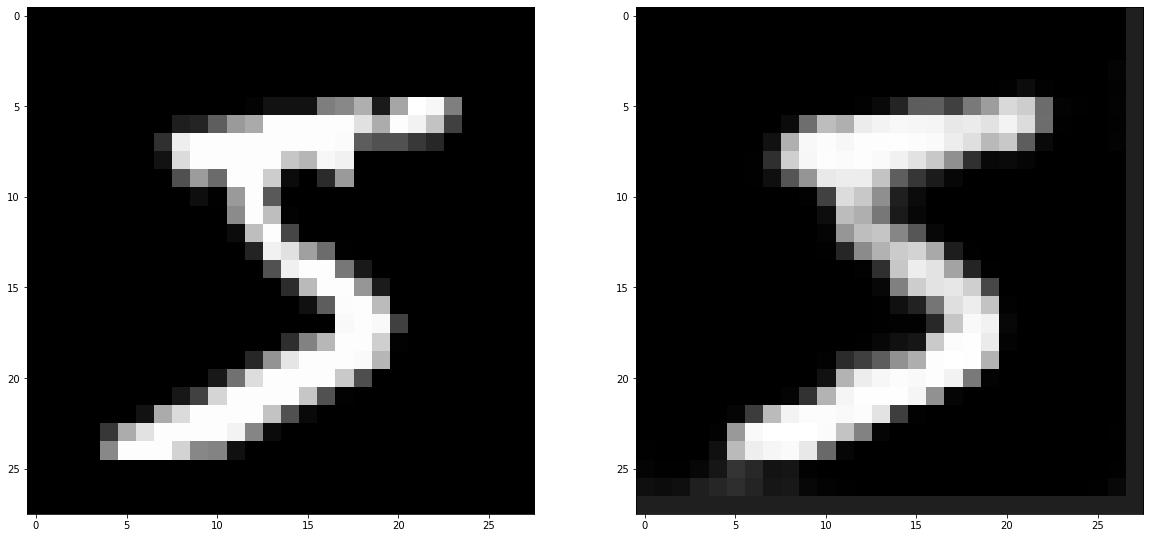

In [50]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
loss_function = nn.MSELoss()
for i_epoch in range(6):
    epoch_loss = 0
    for i_batch, (value_batched, label_batched) in enumerate(data_loader):
        output = autoencoder(value_batched)
        loss = loss_function(output, value_batched)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(epoch_loss)

a = plot(autoencoder, t)

In [59]:
mu, sigma = 0, 0.1
autoencoder_gauss = Autoencoder(1, [4, 8], 28, 28, 3, 2, 0, 64)

In [60]:
optimizer = torch.optim.Adam(autoencoder_gauss.parameters(), lr=0.001)
loss_function = nn.MSELoss()
for i_epoch in range(6):
    epoch_loss = 0
    for i_batch, (value_batched, label_batched) in enumerate(data_loader):
        filter_batched = gauss_filter(value_batched, mu, sigma)
        output = autoencoder_gauss(filter_batched)
        loss = loss_function(output, value_batched)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(epoch_loss)

51.06819771975279
24.9119552411139
13.251472484320402
9.714597569778562
7.7027364587411284
6.425645196810365


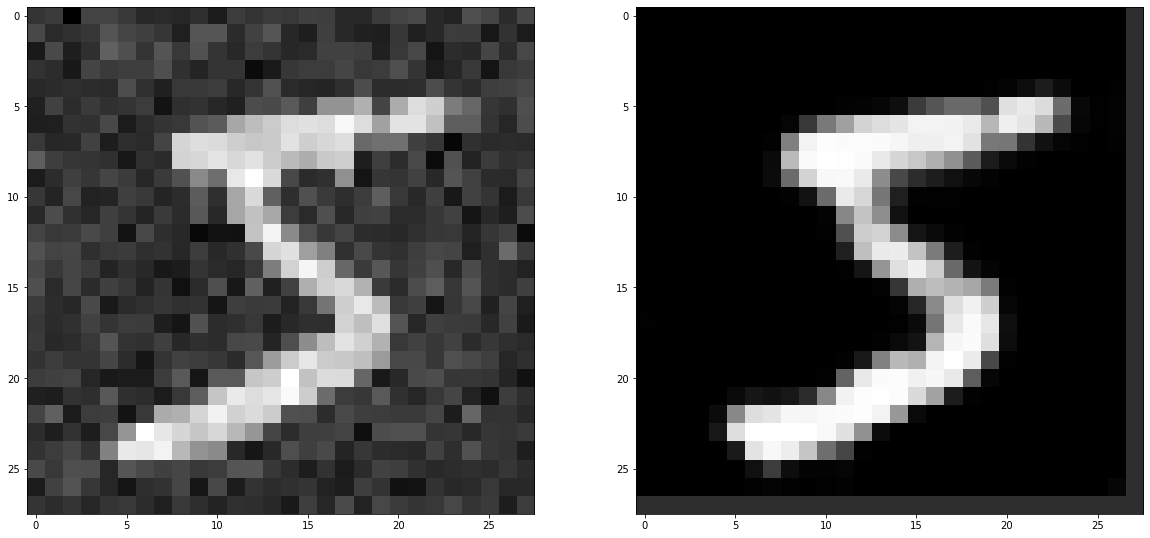

In [64]:
a = plot(autoencoder_gauss, gauss_filter(t, mu, sigma))

In [67]:
zero_chance, fill_chance = 0.1, 0.1
autoencoder_missing_pixels = Autoencoder(1, [4, 8], 28, 28, 3, 2, 0, 64)

In [68]:
optimizer = torch.optim.Adam(autoencoder_missing_pixels.parameters(), lr=0.001)
loss_function = nn.MSELoss()
for i_epoch in range(3):
    epoch_loss = 0
    for i_batch, (value_batched, label_batched) in enumerate(data_loader):
        filter_batched = remove_pixel_filter(value_batched, zero_chance, fill_chance, 1)
        output = autoencoder_missing_pixels(filter_batched)
        loss = loss_function(output, value_batched)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(epoch_loss)

52.31222923845053
36.850029069930315
32.02884153276682


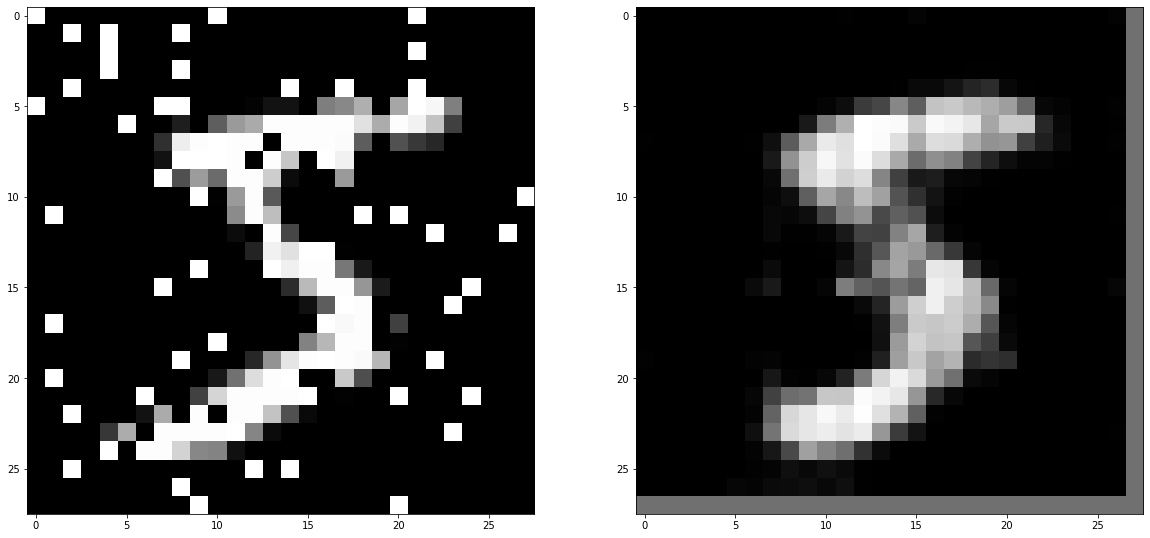

In [69]:
a = plot(autoencoder_missing_pixels, remove_pixel_filter(t, zero_chance, fill_chance, 1))

In [10]:
n = 200
autoencoder_missing_pixels_2 = Autoencoder(1, [4, 8], 28, 28, 3, 2, 0, 64)

In [11]:
optimizer = torch.optim.Adam(autoencoder_missing_pixels_2.parameters(), lr=0.001)
loss_function = nn.MSELoss()
for i_epoch in range(8):
    epoch_loss = 0
    for i_batch, (value_batched, label_batched) in enumerate(data_loader):
        filter_batched = change_n_pixel_filter(value_batched, n)
        output = autoencoder_missing_pixels_2(filter_batched)
        loss = loss_function(output, value_batched)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(epoch_loss)

55.86171019822359
40.03779060021043
34.30413994938135
25.851174518465996
22.10169640928507
20.0778220128268
18.871043499559164
18.067000033333898


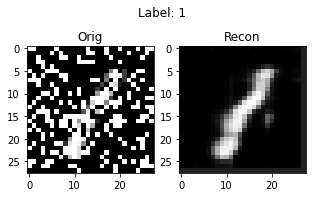

In [23]:
idx = 3
t, label = mnist[idx]
a = plot(autoencoder_missing_pixels_2, change_n_pixel_filter(t, n), figsize=(5, 3), label=label)